# Saddle-to-Saddle Dynamics in Diagonal Linear Networks

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

## Empirics

In [3]:
# Predict and Loss functions
def predict(X, weights):
    d = X.shape[1]
    beta = np.ones(d)
    for w in weights:
        beta *= w
    return X @ beta

def mse_loss(X, y, weights):
    y_pred = predict(X, weights)
    residual = y_pred - y
    return 0.5 * np.mean(residual**2)

# Gradient computation
def gradient(X, y, weights):
    n = X.shape[0]
    y_pred = predict(X, weights)
    residual = y_pred - y
    beta = np.ones(d)
    for w in weights:
        beta *= w
    grads = []
    for l in range(L):
        beta_without_wl = np.ones(d)
        for j in range(L):
            if j != l:
                beta_without_wl *= weights[j]
        grad_wl = (1.0 / n) * (X * beta_without_wl).T @ residual
        grads.append(grad_wl)
    return grads

## Theory

In [4]:
# Implements AGF
def AGF(X, y, alpha, tol_grad=1e-9):
    # Initialization
    residual = y
    dormant, active = [i for i in range(d)], []
    scale = np.sqrt(2) * alpha 
    t = 0.0
    norm = scale * np.ones(d)
    sgns = np.zeros(d)
    
    # Statistics to track
    step = 0
    levels = [0.5 * np.mean(residual**2)]
    times = [t]
    coefs = [np.zeros(d)]
    
    while len(dormant) > 0:
    
        # 1. Compute Max Utility
        grad_beta = -residual @ X / n
        max_util = np.array([np.abs(grad_beta[i]) / 2 for i in dormant])
        sigma = np.array([sgns[i] * np.sign(grad_beta[i]) for i in dormant])
        c = sigma * np.array([np.arccosh(norm[i]**2 / scale**2) for i in dormant])
    
        # 2. Compute taus
        tau_candidates = (np.arccosh(1/scale**2) - c) / (4 * max_util)
    
        # 3. Next emergent neuron
        tau = np.min(tau_candidates)
        idx = dormant[np.argmin(tau_candidates)]
        
        # 4. Update norm, sgns, t
        norm[dormant] = scale * np.sqrt(np.cosh(4 * max_util * tau + c))
        sgns[dormant] = np.sign(4 * max_util * tau + c) * np.sign(grad_beta[dormant])
        t += tau
        active.append(idx)
        dormant.remove(idx)
        
        # 5. Compute new beta
        U_max = (y @ X)[active]
        C_min = X[:, active].T @ X[:, active]
        new_beta = np.linalg.pinv(C_min) @ U_max
        beta = np.zeros(d)
        beta[active] = new_beta
    
        # 6. Check for sign changes, remove flipped indices, and recompute beta
        sign_changes = [i for i in active if beta[i] * coefs[-1][i] < 0]
        if sign_changes:
            for i in sign_changes:
                active.remove(i)
                dormant.append(i)
            # lognorms[sign_changes] = np.log(np.sqrt(2) * alpha) # WHAT IS THE CORRECT REINITIALIZATION?
            U_max = (y @ X)[active]
            C_min = X[:, active].T @ X[:, active]
            beta = np.zeros(d)
            beta[active] = np.linalg.pinv(C_min) @ U_max
            print("Active neurons {} became dormant".format(sign_changes))
    
        # 7. Update residual and store results
        step += 1
        residual = y - X @ beta
        levels.append(0.5 * np.mean(residual**2))
        times.append(t)
        coefs.append(beta.copy())
        print(f"Step {step}: time: {round(t,3)}, active {active}")
    return levels, coefs, times

In [5]:
def constrained_minimization(s, X, y):
    """ Solves min_beta (1/2n) ||Xβ - y||^2 s.t. sign constraints from s using least squares """
    n, d = X.shape
    
    # Define initial bounds
    lower_bounds = np.full(d, -np.inf)  # Default to no lower bound
    upper_bounds = np.full(d, np.inf)   # Default to no upper bound
    
    # Apply constraints:
    lower_bounds[np.isclose(s, 1, atol=1e-9)] = 0 # β_i >= 0 if s_i = +1
    upper_bounds[np.isclose(s, -1, atol=1e-9)] = 0 # β_i <= 0 if s_i = -1
    
    # Fix β_i = 0 for all -1 < s < 1
    mask = ~np.isclose(s, 1, atol=1e-9) & ~np.isclose(s, -1, atol=1e-9)
    lower_bounds[mask] = -1e-10
    upper_bounds[mask] = 1e-10

    # Solve constrained least squares
    result = scipy.optimize.lsq_linear(X, y, bounds=(lower_bounds, upper_bounds), method='trf')

    return result.x 


# Implements Algorithm 1: Successive saddles and jump times
def pesme_flammarion(X, y, tol_grad=1e-9):
    t = 0.0
    beta = np.zeros(d)
    s = np.zeros(d)
    grad_beta = -y @ X

    loss_list = [0.5 * np.mean(y**2)]
    beta_list = [beta.copy()]
    t_list = [0]
    s_list = [s.copy()]
    learned = []
        
    while np.linalg.norm(grad_beta) > tol_grad:
        # 1. Set A = { j | ∇L(β)_j ≠ 0 }
        A = np.where(np.abs(grad_beta) > tol_grad)[0]
    
        # 2. Compute ∆ as inf { δ > 0 | ∃ i in A, s(i) - δ∇L(β)(i) = ±1 }
        delta_candidates = []
        indices = []
        for i in A:
            g_i = grad_beta[i]
            for boundary in [+1, -1]:
                delta = (s[i] - boundary) / g_i
                if delta > 0:
                    delta_candidates.append(delta)
                    indices.append(i)
        delta = np.min(delta_candidates)
        idx = indices[np.argmin(delta_candidates)]
    
        # 3. Update (t, s)
        t += delta
        s -= delta * grad_beta
        s = np.clip(s, -1.0, 1.0)
    
        # 4. Compute β under sign constraints
        beta = constrained_minimization(s, X, y)
        residual = y - beta.T @ X.T
        grad_beta = -residual @ X
    
        # 5. Store results
        loss_list.append(0.5 * np.mean(residual**2))
        beta_list.append(beta.copy())
        t_list.append(t)
        s_list.append(s.copy())
        learned.append(idx)

    print("Learned indices: {}".format(learned))
    return loss_list, beta_list, t_list, s_list

## Plotting

In [6]:
def style_axes(ax, numyticks=5, numxticks=5, xlabels=True, ylabels=True):
    
    plt.rc("font", family='stixgeneral', size=14)
    plt.rc("mathtext", fontset='cm')
    
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=ylabels, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=xlabels, left=True, right=False,
                   labelleft=True, direction='out', length=7, width=1.5, pad=8, labelsize=24)
    # ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))
    ax.xaxis.offsetText.set_fontsize(20)

    # Remove top/right borders and set linewidth
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(3)

In [7]:
def style_polar_axes(ax, num_yticks=5, num_xticks=9):
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt

    # Font settings
    plt.rc("font", family='stixgeneral', size=14)
    plt.rc("mathtext", fontset='cm')

    # Radial (r) axis settings
    ax.yaxis.set_major_locator(ticker.MaxNLocator(num_yticks))
    ax.tick_params(axis="y", which="both",
                   direction='out', length=5, width=1.5, pad=8,
                   labelsize=24)

    # Angular (theta) axis settings
    ax.xaxis.set_major_locator(ticker.MaxNLocator(num_xticks))
    ax.tick_params(axis="x", which="both",
                   direction='out', length=5, width=1.5, pad=8,
                   labelsize=24)

    # Remove polar frame border if desired (optional)
    ax.spines['polar'].set_linewidth(2)

In [8]:
def style_heatmap_axes(ax, num_yticks=5, num_xticks=5):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    # Font settings
    plt.rc("font", family='stixgeneral', size=14)
    plt.rc("mathtext", fontset='cm')

    # Major ticks settings
    ax.xaxis.set_major_locator(ticker.MaxNLocator(num_xticks))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(num_yticks))

    ax.tick_params(axis="both", which="both",
                   direction='out', length=6, width=1.5, pad=8,
                   labelsize=24)

    # Axis styling
    ax.xaxis.offsetText.set_fontsize(12)
    ax.yaxis.offsetText.set_fontsize(12)
    
    # Grid (optional for heatmaps, often turned off)
    ax.grid(False)

    # Thicken bottom/left spines
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_linewidth(2)

    # Aspect ratio (optional, often good for heatmaps)
    ax.set_aspect('auto')  # or 'equal' if square pixels are needed


## Experiments

### Illustrative 2D example

In [814]:
# Illustrative 2d example from section 3.1 of Pesme & Flammarion, 2023

# Problem setup
d, n = 2, 2  # dimension and number of samples

# Define X such that X^T X = [[1, 0.2], [0.2, -0.2]]
# This doesn't make sense because the given matrix is not PSD.
theta = np.deg2rad(150)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
Lambda = np.diag([1.0, 25.0])
XtX = R @ Lambda @ R.T
X = np.linalg.cholesky(XtX)

# Define true beta
beta_true = np.array([-0.2, 2.0])

# Outputs
y = X @ beta_true

# Gradient descent parameters
learning_rate = 0.0001
max_iters = int(1e6)
L = 2  # Lipschitz constant or step size control (if you use it)

# Initialize parameters small
beta = 1e-5 * np.random.randn(d)

# Now track losses and betas
alphas = [0.5, 1e-1, 1e-2, 1e-4, 1e-6]
all_losses = {}
all_betas = {}
all_weights = {}

for alpha in alphas:
    weights = [np.sqrt(2) * alpha * np.ones(d) for _ in range(L - 1)] + [np.zeros(d)]
    losses = []
    betas = []
    weight_history = []
    for it in range(max_iters):
        current_loss = mse_loss(X, y, weights)
        losses.append(current_loss)
        # Save current beta
        beta_now = np.ones(d)
        for w in weights:
            beta_now *= w
        betas.append(beta_now.copy())
        # Save current weights
        weight_history.append([w.copy() for w in weights])
        
        grads = gradient(X, y, weights)
        for l in range(L):
            weights[l] -= learning_rate * grads[l]
    all_losses[alpha] = losses
    all_betas[alpha] = betas
    all_weights[alpha] = weight_history

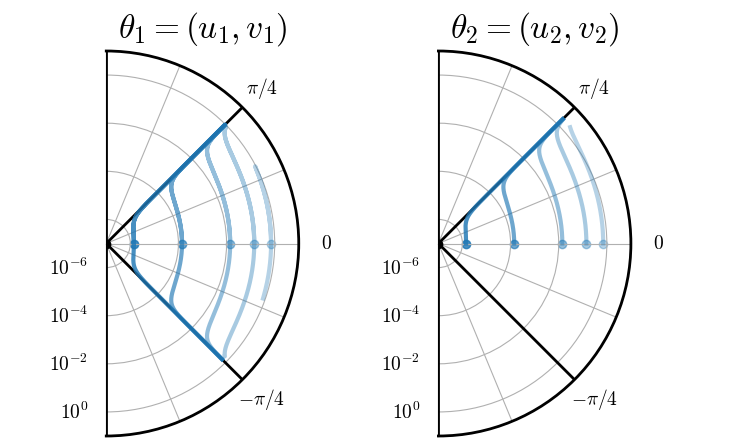

In [834]:
base_color = "#1f77b4"  # Set the base color for all lines
def normalized_alpha(alpha):
    return min(1, max(0.3, 0.3 + 0.7 * (-np.log(alpha) / -np.log(1e-8))))

# Create two polar plots
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(10, 5))

# Setup
r_min, r_max = 1e-7, 1e1
colors = plt.cm.tab10.colors
k = -1

for idx_alpha, (alpha, weights) in enumerate(all_weights.items()):

    weight_list = np.array(weights)  # (iterations, 2, d)
    num_iters, _, d = weight_list.shape

    # Compute norms and angles
    norms = np.linalg.norm(weight_list, axis=1)
    angles = np.arctan2(weight_list[:, 1, :], weight_list[:, 0, :])

    for i in range(d):
        ax = axes[i]
        ax.plot(angles[:k, i], norms[:k, i],
                color=base_color, alpha=normalized_alpha(alpha),
                linestyle='-', lw=3, zorder=10)

        # Optionally plot starting point
        ax.scatter(angles[0, i], norms[0, i], color=base_color, alpha=normalized_alpha(alpha))

# Shared settings for both axes
for i, ax in enumerate(axes):
    # Style plot
    style_polar_axes(ax)
    
    # Balanced lines
    r_vals = np.linspace(r_min, r_max, 200)
    ax.plot(np.full_like(r_vals, np.pi/2), r_vals, color='black', ls='-', lw=2)
    ax.plot(np.full_like(r_vals, -np.pi/2), r_vals, color='black', ls='-', lw=2)
    ax.plot(np.full_like(r_vals, np.pi/4), r_vals, color='black', ls='-', lw=2)
    ax.plot(np.full_like(r_vals, -np.pi/4), r_vals, color='black',ls='-', lw=2)
    ax.scatter(0, r_min, color='black', zorder=10)

    ax.set_yscale('log')
    ax.set_ylim(r_min, r_max)
    ax.set_yticks([1e-6, 1e-4, 1e-2, 1e0])
    ax.set_yticklabels([r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$'])

    # Half-circle
    ax.set_thetagrids(np.linspace(-90, 90, 9))
    ax.set_xticklabels(['', '', r'$-\pi/4$', '', r'$0$', '', r'$\pi/4$', '', ''])
    ax.set_xlim(-np.pi/2, np.pi/2)

    ax.set_title(r'$\theta_{} = (u_{}, v_{})$'.format(i+1, i+1, i+1), fontsize=24, pad=10)

# 🛠 TIGHT SPACING:
fig.subplots_adjust(wspace=-0.25)  # <-- tighten horizontal space
plt.savefig("theta.pdf", dpi=300, bbox_inches='tight')
plt.show()

Learned indices: [0, 1, 0]


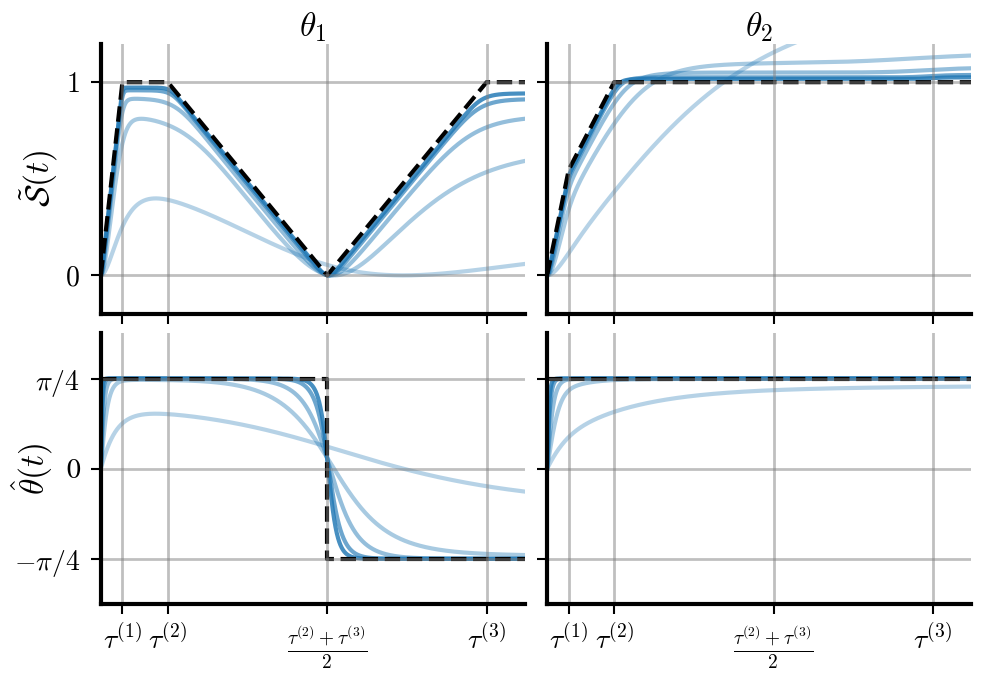

In [841]:
base_color = "#1f77b4"  # Set the base color for all lines
def normalized_alpha(alpha):
    return min(1, max(0.3, 0.3 + 0.7 * (-np.log(alpha) / -np.log(1e-8))))

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True)

# Empirics
for idx_alpha, (alpha, weights) in enumerate(all_weights.items()):

    weight_list = np.array(weights)
    num_iters, _, d = weight_list.shape
    
    u = weight_list[:, 0, :]
    v = weight_list[:, 1, :]
    
    angles = np.arctan2(v, u)
    norms = np.linalg.norm(np.stack([u, v], axis=-1), axis=-1)

    # grads = [gradient(X, y, weights) for weights in weight_list]
    
    log_norms = np.log(norms)
    log_norms_shifted = log_norms - log_norms[0, :]

    rescaled_time = 1 / -np.log(alpha) * np.arange(len(norms))

    for i in range(d):
        # Top row: Norms
        axes[0, i].plot(rescaled_time, log_norms_shifted[:, i] / -np.log(alpha), 
                        color=base_color, alpha=normalized_alpha(alpha), lw=3)
        # Bottom row: Angles
        axes[1, i].plot(rescaled_time, angles[:, i], 
                        color=base_color, alpha=normalized_alpha(alpha), lw=3)

# Theory
loss_list, beta_list, t_list, s_list = pesme_flammarion(X, y)
time_sequence = n * np.array(t_list) / learning_rate  # Normalize time
s_array = np.array(s_list)

# Add extra point
time_sequence = np.append(time_sequence, rescaled_time[-1])
s_array = np.vstack([s_array, s_array[-1]])

def insert_zero_crossings(time_sequence, s_array_i):
    time_sequence = np.array(time_sequence)
    s_array_i = np.array(s_array_i)

    new_times, new_s = [time_sequence[0]], [s_array_i[0]]

    for t0, t1, s0, s1 in zip(time_sequence[:-1], time_sequence[1:], s_array_i[:-1], s_array_i[1:]):
        if s0 * s1 < 0:
            new_times.append(0.5 * (t0 + t1))
            new_s.append(0.0)
        new_times.append(t1)
        new_s.append(s1)

    return np.array(new_times), np.array(new_s)

def sign_flip_angles(s):
    sign_s = np.sign(s)
    for k in range(len(sign_s) - 1):
        if sign_s[k] == 0:
            sign_s[k] = sign_s[k+1]
    return np.where(sign_s > 0, np.pi/4, -np.pi/4)

for i in range(d):  # loop over coordinates
    times, s = insert_zero_crossings(time_sequence, s_array[:, i])
    angles = sign_flip_angles(s)
    axes[0, i].plot(times, np.abs(s), color='k', ls='--', lw=3)
    axes[1, i].step(times, angles, where='post', color='k', ls='--', lw=3)


# Plot vertical and horizontal lines
times, s = insert_zero_crossings(time_sequence, s_array[:, 0])
for i, tau in enumerate(times[1:-1]):
    for ax in axes.flat:
        ax.axvline(x=tau, color='grey', alpha=0.5, linestyle='-', linewidth=2)

axes[0,0].set_xticks(times[1:-1])
axes[0,0].set_xticklabels([r'$\tau^{(1)}$', r'$\tau^{(2)}$', r'$\frac{\tau^{(2)} + \tau^{(3)}}{2}$', r'$\tau^{(3)}$'])


for i, angle in enumerate([-np.pi/4, 0, np.pi/4]):
    for ax in axes[1, :].flat:
        ax.axhline(y=angle, color='grey', alpha=0.5, linestyle='-', linewidth=2)

for i, s in enumerate([0, 1]):
    for ax in axes[0, :].flat:
        ax.axhline(y=s, color='grey', alpha=0.5, linestyle='-', linewidth=2)


# --- Axis settings ---
for i in range(2):
    # Top row: Norms
    style_axes(axes[0, i], xlabels=False)
    axes[0, i].set_ylim(-0.2, 1.2)
    axes[0, i].set_xlim(0, 38000)
    axes[0, i].set_title(r'$\theta_{}$'.format(i+1), fontsize=24, pad=-10)
    axes[0, i].set_yticks(np.linspace(0, 1, 2))
    if i == 0:
        axes[0, i].set_ylabel(r'$\tilde{\mathcal{S}}(t)$', fontsize=24)
        axes[0, i].set_yticklabels([r'$0$', r'$1$'], fontsize=20)
    else:
        axes[0, i].yaxis.set_tick_params(labelleft=False)
        axes[0, i].set_ylabel('')

    # Bottom row: Angles
    style_axes(axes[1, i], xlabels=True)
    axes[1, i].set_ylim(-np.pi*3/8, np.pi*3/8)
    axes[1, i].set_xlim(0, 38000)
    axes[1, i].set_yticks([-np.pi/4, 0, np.pi/4])
    if i == 0:
        axes[1, i].set_ylabel(r'$\hat{\theta}(t)$', fontsize=24, labelpad=-30)
        axes[1, i].set_yticklabels([r'$-\pi/4$', '0', r'$\pi/4$'], fontsize=20)
    else:
        axes[1, i].yaxis.set_tick_params(labelleft=False)
        axes[1, i].set_ylabel('')

# 🛠 Tighter Layout
plt.tight_layout(pad=1.0, w_pad=0.65, h_pad=0.5)
plt.savefig("utility.pdf", dpi=300, bbox_inches='tight')
plt.show()

Learned indices: [0, 1, 0]


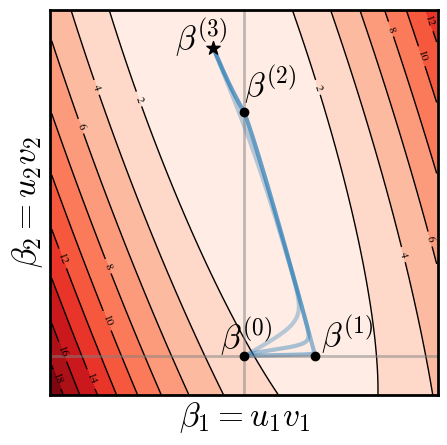

In [839]:
base_color = "#1f77b4"  # Set the base color for all lines
def normalized_alpha(alpha):
    return min(1, max(0.3, 0.3 + 0.7 * (-np.log(alpha) / -np.log(1e-8))))

# Set up grid for beta values
grid_size = 100
xlim = (-1.25, 1.25)
ylim = (-0.25, 2.25)
beta1 = np.linspace(xlim[0], xlim[1], grid_size)
beta2 = np.linspace(ylim[0], ylim[1], grid_size)
B1, B2 = np.meshgrid(beta1, beta2)

# Compute the MSE loss over the grid
Loss = np.zeros_like(B1)
for i in range(grid_size):
    for j in range(grid_size):
        weights = [np.array([B1[i, j], B2[i, j]])]
        Loss[i, j] = mse_loss(X, y, weights)

# --- Corrected Plotting ---
fig, ax = plt.subplots(figsize=(5,5))  # <- create fig and ax!

# Heatmap + contours
contours = ax.contourf(B1, B2, Loss, levels=10, cmap='Reds')
contours = ax.contour(B1, B2, Loss, levels=10, colors='black', linewidths=1)
ax.clabel(contours, inline=True, fontsize=8)

# Trajectories
for alpha, betas in all_betas.items():
    if alpha in [0.5, 1e-1, 1e-2, 1e-8]:
        formatted_scale = f'{alpha:.0e}' if alpha < 0.1 else f'{alpha:.2f}'
        betas = np.array(betas)
        ax.plot(betas[:, 0], betas[:, 1], 
                color=base_color, alpha=normalized_alpha(alpha),
                label=f'α = {formatted_scale}', lw=3)

# AGF trajectory
loss_list, beta_list, t_list, s_list = pesme_flammarion(X, y)
beta_array = np.array(beta_list)
ax.scatter(beta_array[:-1, 0], beta_array[:-1, 1], color='k', zorder=100)
ax.scatter(beta_array[-1, 0], beta_array[-1, 1], color='k', marker='*', s=100, zorder=101)
# This should be the heteroclinic orbit (which will depend on XtX)
# ax.plot(beta_array[:, 0], beta_array[:, 1], color='k', ls='--', lw=1.5)

# Beta labels
shifts = [(-0.16, -0.01), (0.04, 0), (0, 0.04), (-0.25, -0.07)]
for i, (beta1, beta2) in enumerate(beta_array):
    si = shifts[i]
    ax.text(beta1 + si[0], beta2 + si[1], rf'$\beta^{{({i})}}$', fontsize=24, ha='left', va='bottom')

# Axes lines
ax.axhline(0, color='grey', alpha=0.5, linestyle='-', linewidth=2)
ax.axvline(0, color='grey', alpha=0.5, linestyle='-', linewidth=2)

# --- Style Axes ---
style_heatmap_axes(ax)

ax.set_xlabel(r'$\beta_1 = u_1v_1$', fontsize=24)
ax.set_xticks([])
ax.set_ylabel(r'$\beta_2 = u_2v_2$', fontsize=24)
ax.set_yticks([])
ax.axis('equal')
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])

plt.savefig("beta.pdf", dpi=300, bbox_inches='tight')
plt.show()

Learned indices: [0, 1, 0]
Step 1: time: 2.667, active [0]
Active neurons [0] became dormant
Step 2: time: 8.292, active [1]
Step 3: time: 47.765, active [1, 0]


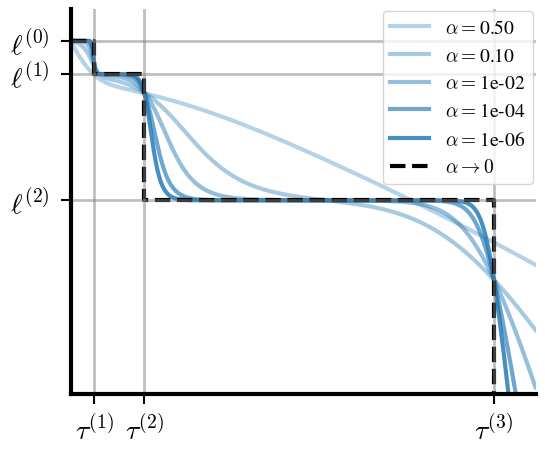

In [826]:
base_color = "#1f77b4"  # Set the base color for all lines
def normalized_alpha(alpha):
    return min(1, max(0.3, 0.3 + 0.7 * (-np.log(alpha) / -np.log(1e-8))))

# Plotting Empirics
fig, ax = plt.subplots(figsize=(6, 5))
for alpha, losses in all_losses.items():
    formatted_scale = f'{alpha:.0e}' if alpha < 0.1 else f'{alpha:.2f}'
    ax.plot(1/-np.log(alpha) * range(max_iters), losses, 
            color=base_color, alpha=normalized_alpha(alpha), 
            label=r'$\alpha =$' + formatted_scale, lw=3)


# Plotting Theory
loss_list, beta_list, t_list, s_list = pesme_flammarion(X, y)
time_sequence = n * np.array(t_list) / learning_rate  # Normalize time
loss_list, beta_list, t_list = AGF(X, y, alpha, tol_grad=1e-9)
time_sequence = 1/-np.log(alpha) * np.array(t_list) / learning_rate  # Normalize time
plt.step(time_sequence, loss_list, linestyle='--', color='k', where='post', label=r'$\alpha \to 0$', lw=3)

# Plot vertical and horizontal lines
for i, tau in enumerate(time_sequence):
    ax.axvline(x=tau, color='grey', alpha=0.5, linestyle='-', linewidth=2)
for i, ell in enumerate(loss_list):
    ax.axhline(y=ell, color='grey', alpha=0.5, linestyle='-', linewidth=2)


ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlabel('Iteration', fontsize=24)
# ax.set_ylabel(r'$\mathcal{L}$', fontsize=24)
ax.set_xlim(0, 38000)
ax.set_ylim(1e-3, 2 * losses[0])

ax.set_xticks(time_sequence[1:])
ax.set_xticklabels([r'$\tau^{(1)}$', r'$\tau^{(2)}$', r'$\tau^{(3)}$'])

ax.set_yticks(loss_list[:-1])
ax.set_yticklabels([r'$\ell^{(0)}$', r'$\ell^{(1)}$', r'$\ell^{(2)}$'])
ax.yaxis.set_minor_locator(plt.NullLocator())

ax.legend(title="", loc='upper left', bbox_to_anchor=(0.65, 1.02))
style_axes(ax)
plt.savefig("loss.pdf", dpi=300, bbox_inches='tight')

### Highdimensional Example

In [9]:
np.random.seed(10)

# Hyperparameters & Setup
d, n, exponent = 5, 20, 1
cov_diag = np.power(np.arange(1, d+1, dtype=float), -exponent)
X = np.random.multivariate_normal(np.zeros(d), np.diag(cov_diag), size=n)
beta_true = 10 * np.random.randn(d)
y = X @ beta_true

# Gradient descent parameters
learning_rate = 0.001
max_iters = int(1e6)
L = 2

# Experiment for different alpha values
alphas = [0.99, 0.9, 0.5, 1e-1, 1e-2, 1e-4, 1e-8, 1e-16]
all_losses = {}
all_betas = {}

for alpha in alphas:
    weights = [np.sqrt(2) * alpha * np.ones(d) for _ in range(L - 1)] + [np.zeros(d)]
    losses = []
    betas = []
    for it in range(max_iters):
        current_loss = mse_loss(X, y, weights)
        losses.append(current_loss)
        # Save current beta
        beta_now = np.ones(d)
        for w in weights:
            beta_now *= w
        betas.append(beta_now.copy())
        grads = gradient(X, y, weights)
        for l in range(L):
            weights[l] -= learning_rate * grads[l]
    all_losses[alpha] = losses
    all_betas[alpha] = betas

Learned indices: [1, 2, 3, 0, 4]
Step 1: time: 27.659, active [1]
Step 2: time: 138.315, active [1, 2]
Step 3: time: 226.047, active [1, 2, 3]
Step 4: time: 256.113, active [1, 2, 3, 0]
Step 5: time: 971.519, active [1, 2, 3, 0, 4]


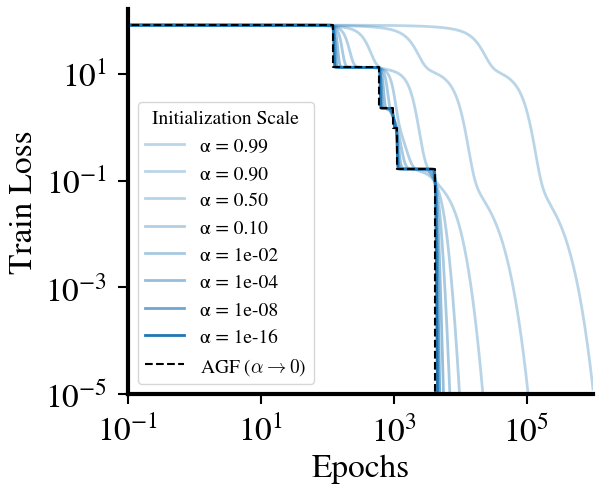

In [18]:
# Plotting Empirics
fig, ax = plt.subplots(figsize=(6, 5))
base_color = "#1f77b4"  # Set the base color for all lines

for alpha, losses in all_losses.items():
    # if alpha in [0.99, 0.9, 0.5, 1e-1, 1e-2, 1e-8]:
    # Normalize alpha for opacity (between 0.2 and 1 for better visibility)
    normalized_alpha = min(1, max(0.3, 0.3 + 0.7 * (-np.log(alpha) / -np.log(1e-16))))
    formatted_scale = f'{alpha:.0e}' if alpha < 0.1 else f'{alpha:.2f}'
    ax.plot(1/-np.log(alpha) * range(max_iters), losses, label=f'α = {formatted_scale}', 
            lw=2, color=base_color, alpha=normalized_alpha)

# Plotting Theory
alpha = 1e-100
loss_list, beta_list, t_list, s_list = pesme_flammarion(X, y)
time_sequence = n * np.array(t_list) / learning_rate  # Normalize time
loss_list, beta_list, t_list = AGF(X, y, alpha, tol_grad=1e-9)
time_sequence = 1/-np.log(alpha) * np.array(t_list) / learning_rate  # Normalize time
plt.step(time_sequence, loss_list, linestyle='--', color='k', where='post', label=r'AGF ($\alpha \to 0$)', lw=1.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel('Train Loss', fontsize=24)
ax.set_ylim(1e-5, 2 * losses[0])
ax.set_xlim(1e-1,1e6)
ax.grid(False)
ax.legend(title="Initialization Scale")
style_axes(ax)
plt.savefig("loss-sweep.pdf", dpi=300, bbox_inches='tight')
plt.show()

Learned indices: [1, 2, 3, 0, 4]
Step 1: time: 27.659, active [1]
Step 2: time: 138.315, active [1, 2]
Step 3: time: 226.047, active [1, 2, 3]
Step 4: time: 256.113, active [1, 2, 3, 0]
Step 5: time: 971.519, active [1, 2, 3, 0, 4]


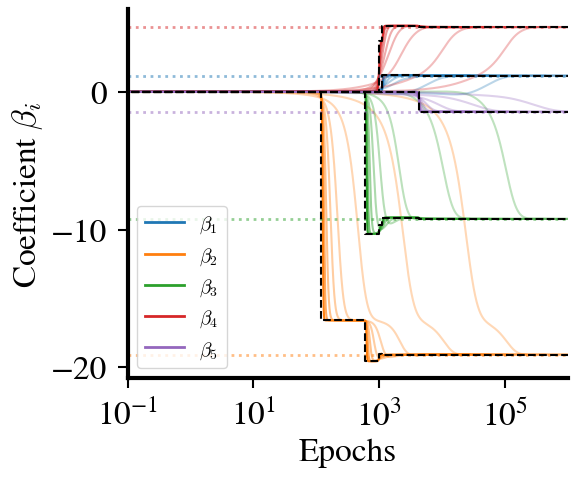

In [21]:
# Plotting β_i(t) for each coordinate and alpha
fig, ax = plt.subplots(figsize=(6, 5))

colors = plt.cm.tab10.colors
for i in range(d):  # for each coordinate
    for j, (alpha, beta_seq) in enumerate(all_betas.items()):
        beta_seq = np.array(beta_seq)
        normalized_alpha = min(1, max(0.3, 0.3 + 0.7 * (-np.log(alpha) / -np.log(1e-16))))
        time = 1 / -np.log(alpha) * np.arange(max_iters)
        ax.plot(time, beta_seq[:, i], alpha=normalized_alpha, lw=1.5, color=colors[i])
    legend_line, = ax.plot([], [], color=colors[i], lw=2, label=rf'$\beta_{{{i + 1}}}$')

# Plot OLS solution (horizontal lines)
OLS = np.linalg.inv(X.T @ X) @ X.T @ y
for i, beta_ols in enumerate(OLS):
    ax.axhline(y=beta_ols, color=colors[i], alpha=0.5, linestyle='dotted', linewidth=2)

# Plotting Theory
alpha = 1e-100
loss_list, beta_list, t_list, s_list = pesme_flammarion(X, y)
time_sequence = n * np.array(t_list) / learning_rate  # Normalize time
loss_list, beta_list, t_list = AGF(X, y, alpha, tol_grad=1e-9)
maxepoch = max(max(t_list), max_iters)
t_list += [maxepoch]
time_sequence = 1/-np.log(alpha) * np.array(t_list) / learning_rate  # Normalize time
beta_sequence = np.array(beta_list + [beta_list[-1]])
for i in range(d):
    plt.step(time_sequence, beta_sequence[:, i], where='post', color='k', linestyle='--', lw=1.5)

ax.set_xlabel('Epochs', fontsize=24)
ax.set_ylabel(r'Coefficient $\beta_i$', fontsize=24)
ax.set_xscale('log')
ax.set_xlim(1e-1,1e6)
ax.grid(False)
ax.legend(loc='lower left')
style_axes(ax)
plt.tight_layout()
plt.savefig("beta-sweep.pdf", dpi=300, bbox_inches='tight')
plt.show()